# Project_1 : Text Classification

## 1. Itroduction

영어 문장에 대한 긍정/부정 리뷰를 구분하는 text classification task입니다.

### 1.1 사용 모델

* Bert
* RoBerta : 테스트 결과 가장 성능이 좋게 나왔다.
* Bart
* XLNet



### 1.2 모델 선정 기준
 
 * hugging face의 존재하는 모델이며, 모델의 클래스 중 SequenceClassification 가 있는 경우 
 * 최근에 나온 모델이며, 성능이 좋다고 평가 받는 모델들

* 유튜브 자료(모델 설명) : https://www.youtube.com/watch?v=v7diENO2mEA

## 2. Library Load and Download

In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece
!pip install bertviz
!pip install plotly
!pip install pyyaml==5.4.1

     |████████████████████████████████| 3.1 MB 9.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.4 MB/s 
     |████████████████████████████████| 895 kB 60.1 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 925 kB 7.1 MB/s 
     |████████████████████████████████| 125 kB 83.6 MB/s 
     |████████████████████████████████| 829 kB 64.4 MB/s 
     |████████████████████████████████| 329 kB 61.9 MB/s 
     |████████████████████████████████| 1.1 MB 61.5 MB/s 
     |████████████████████████████████| 160 kB 78.6 MB/s 
     |████████████████████████████████| 271 kB 95.7 MB/s 
     |████████████████████████████████| 192 kB 89.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e9b480f05dcf9e

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim



from transformers import (
    AdamW,
    RobertaForSequenceClassification,
    RobertaModel,
    RobertaTokenizer
)
from tqdm.auto import tqdm
from bertviz import head_view

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc


import warnings

warnings.filterwarnings(action='ignore') 
from plotly import graph_objs as go

from collections import Counter
import plotly.express as px


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10


In [ ]:
pl.seed_everything(42)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Global seed set to 42


## 2. EDA

### 2.1 data_load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def load_data_file(filename):
  train_1ist = []
  with open('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/'+ str(filename), 'r', encoding='utf-8') as f:
    for line in f.readlines():
      train_1ist.append(line.lower()[:-1]) 
      f.close()
      
  data = pd.DataFrame(data=train_1ist, columns=['Id'])
  #labels = [[int(filename[-1])] for i in range(len(data))]
  data['label'] = int(filename[-1])
  return data



In [ ]:
train_df = pd.concat([load_data_file('sentiment.train.0'), load_data_file('sentiment.train.1')], axis=0)
val_df = pd.concat([load_data_file('sentiment.dev.0'), load_data_file('sentiment.dev.1')], axis=0)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/test_no_label.csv')

In [ ]:
train_df=train_df.reset_index().drop('index',axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

In [ ]:
# roberta-base : accuray -> 98.888
# roberta-large : accuary -> 98.89
MODEL_NAME = 'roberta-base'

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

### 2.2 Data EDA

### 2.2.

In [ ]:
text_token_counts = []

for row in tqdm(train_df.Id):
    text_token_count = len(tokenizer.encode(row))
    text_token_counts.append(text_token_count)


  0%|          | 0/443259 [00:00<?, ?it/s]

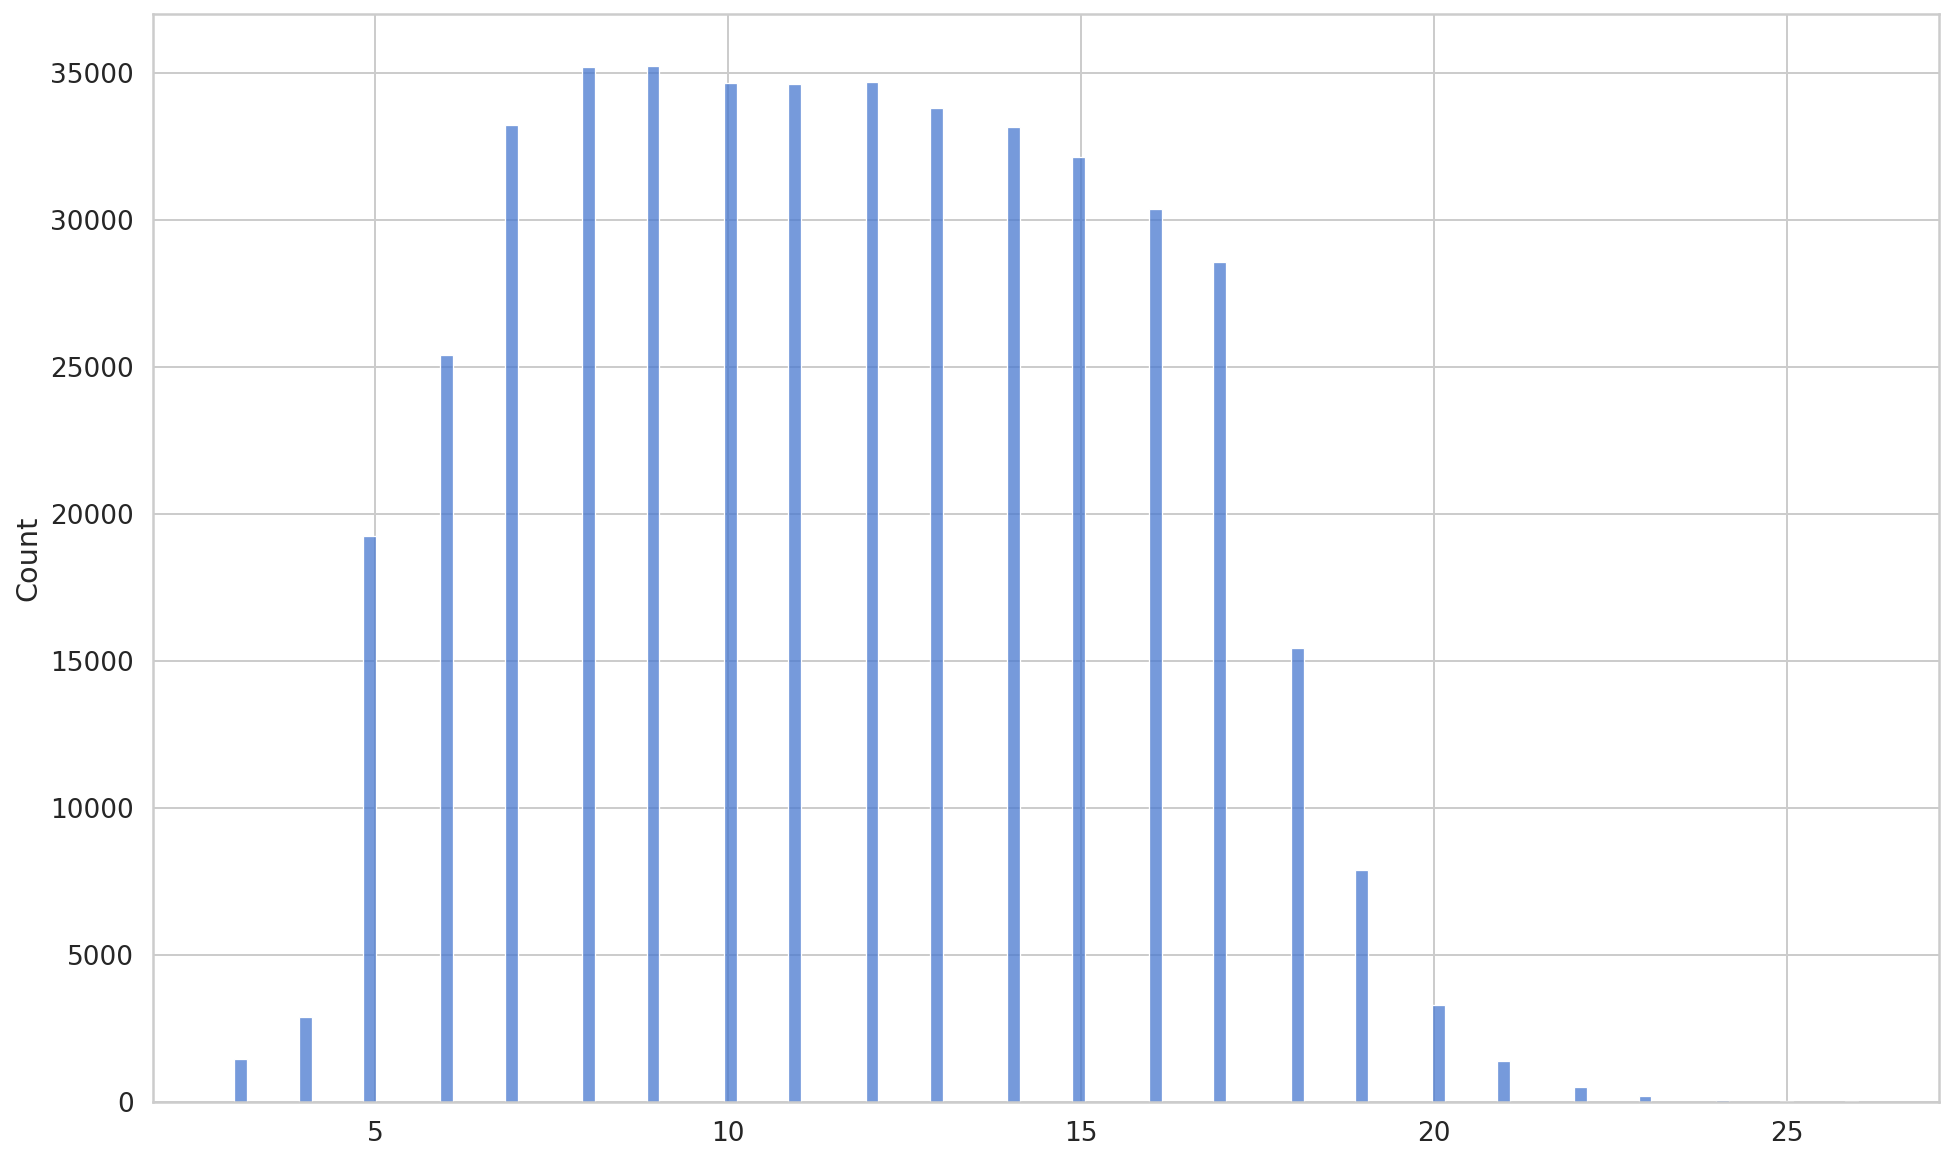

In [ ]:
sns.histplot(text_token_counts)

문장의 길이가 전체적으로 짧다.

In [ ]:
display(train_df.head(2))
display(val_df.head(2))
display(test_df.head(2))


,Id,label
0,i was sadly mistaken .,0
1,"so on to the hoagies , the italian is general ...",0


,Id,label
0,windows have n't been cleaned in years you can...,0
1,waitresses are slow .,0


,Id
0,it 's a whole new experience and new flavors e...
1,so disappointing from an old favorite .


In [ ]:
temp = train_df.groupby('label').count().reset_index().sort_values(by='Id',ascending=False)
display(temp.style.background_gradient(cmap='Blues'))

from plotly import graph_objs as go

fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.Id,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()




,label,Id
1,1,266041
0,0,177218


In [ ]:
temp = val_df.groupby('label').count().reset_index().sort_values(by='Id',ascending=False)
temp.style.background_gradient(cmap='Blues')

,label,Id
0,0,2000
1,1,2000


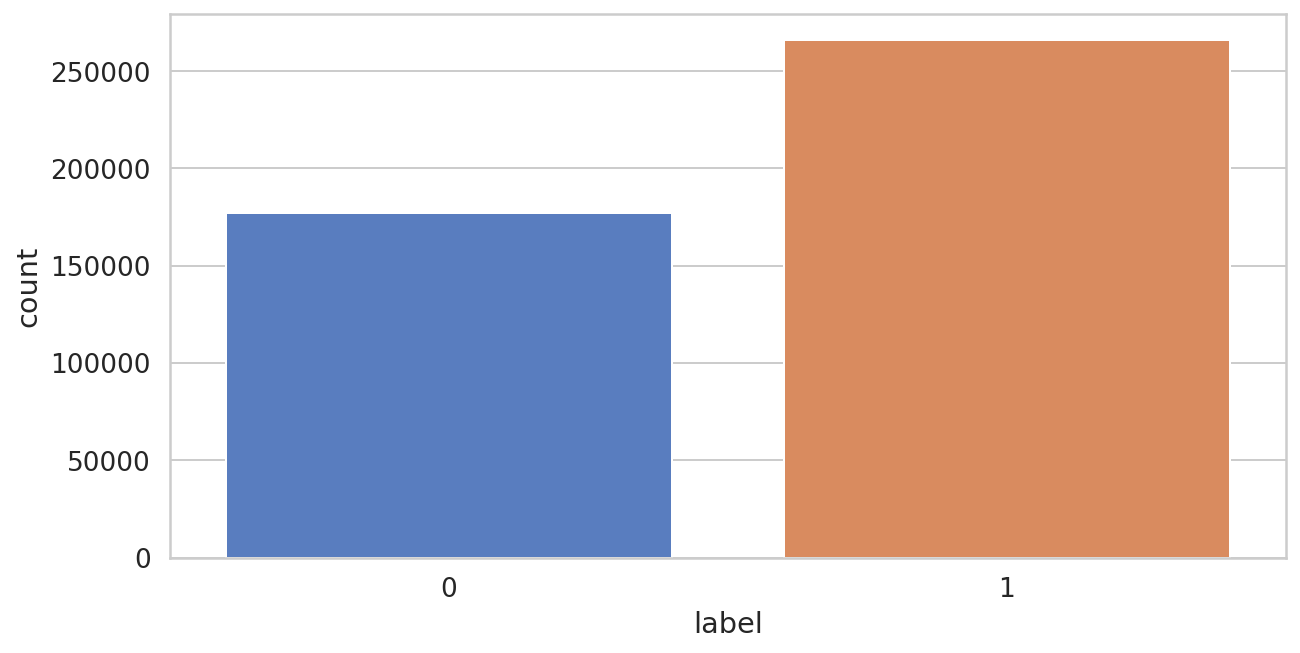

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x='label')

In [ ]:
from collections import Counter
import plotly.express as px

train_df['temp_list'] = train_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Blues'))

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Train Id', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,.,346292
1,the,161149
2,and,125512
3,i,96490
4,!,90030
5,",",85969
6,is,74024
7,was,71592
8,a,69464
9,to,54813


In [ ]:
val_df['temp_list'] = val_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in val_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Greens'))

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Validation Id', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,.,3124
1,the,1480
2,and,1028
3,i,954
4,!,816
5,",",688
6,was,669
7,is,612
8,to,574
9,a,556


In [ ]:
test_df['temp_list'] = test_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in test_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Reds'))



,Common_words,count
0,.,832
1,the,461
2,and,357
3,i,267
4,",",243
5,was,215
6,is,199
7,a,179
8,to,168
9,!,155


* n't를 not으로 전처리하는 작업이 필요해 보인다.
* 특수문자 ., !, ? 등을 제거해야할거같다


In [ ]:
train_df

,Id,label,temp_list
0,i was sadly mistaken .,0,"[i, was, sadly, mistaken, .]"
1,"so on to the hoagies , the italian is general ...",0,"[so, on, to, the, hoagies, ,, the, italian, is..."
2,minimal meat and a ton of shredded lettuce .,0,"[minimal, meat, and, a, ton, of, shredded, let..."
3,nothing really special & not worthy of the $ _...,0,"[nothing, really, special, &, not, worthy, of,..."
4,"second , the steak hoagie , it is atrocious .",0,"[second, ,, the, steak, hoagie, ,, it, is, atr..."
...,...,...,...
443254,love these donuts !,1,"[love, these, donuts, !]"
443255,lots of smiles from everyone .,1,"[lots, of, smiles, from, everyone, .]"
443256,the donuts are delicious .,1,"[the, donuts, are, delicious, .]"
443257,fresh in the morning and conveniently priced .,1,"[fresh, in, the, morning, and, conveniently, p..."


* 불용어를 제거한뒤 문자 카운트

In [ ]:
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]

temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Purples'))
fig = px.treemap(temp, values='count',title='Tree of Most Common Words')
fig.show()

,Common_words,count
1,the,161149
2,and,125512
3,i,96490
4,!,90030
5,",",85969
6,is,74024
7,was,71592
8,a,69464
9,to,54813
10,it,50615


In [ ]:
Positive_sent = train_df[train_df['label']==1]
Negative_sent = train_df[train_df['label']==0]

In [ ]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
display(temp_positive.style.background_gradient(cmap='Greens'))
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,.,189811
1,the,97400
2,and,90825
3,!,74747
4,is,55017
5,",",49038
6,i,46055
7,great,44804
8,a,42494
9,was,33626


In [ ]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
display(temp_negative.style.background_gradient(cmap='Reds'))

fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
1,the,63749
2,i,50435
3,was,37966
4,",",36931
5,and,34687
6,to,29665
7,a,26970
8,not,23378
9,it,23017
10,_num_,21050


In [ ]:
def unique_words(df, col="Id", title="Distribution of number of unique words"):
  fig,ax=plt.subplots(1,2,figsize=(12,7))
  colors = {
        1: "green",
        0 : "red"
        
    }
  for _, i in enumerate([0, 1]):
      new=df[df['label']==i][col].map(lambda x: len(set(x.split())))
      sns.distplot(new.values,ax=ax[_],color=colors[i])
      ax[_].set_title(i)
  fig.suptitle(title)
  fig.show()

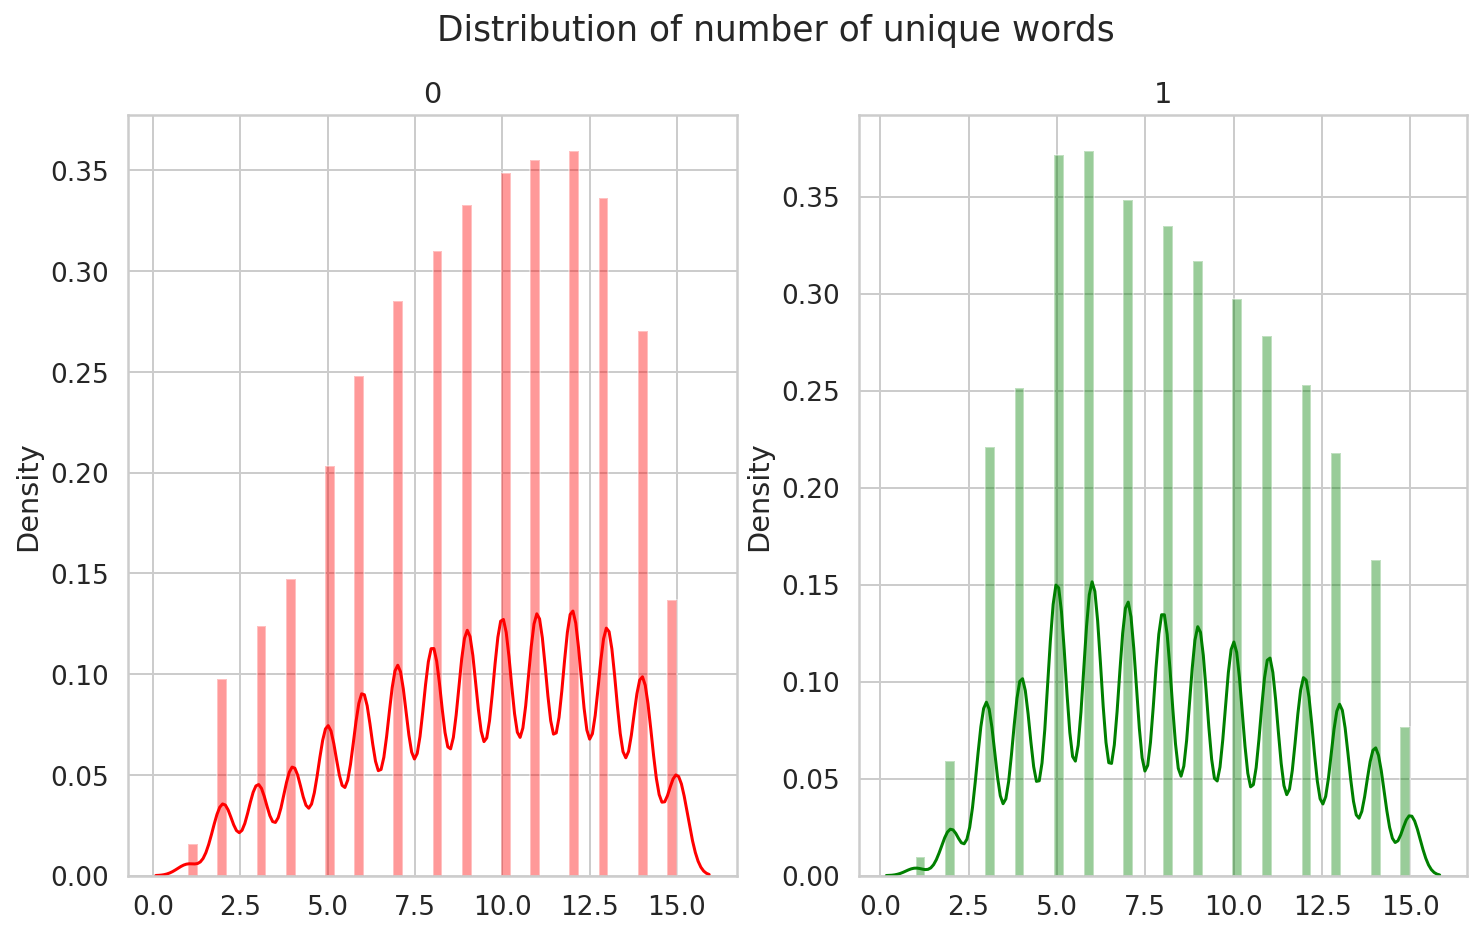

In [ ]:
unique_words(train_df)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]
    
def plot_n_grams(df, size=2, 
                 title="Common bigrams in selected text",
                 label="label",
                 column="Id"):
    colors = {
        1 : "green",
        0 : "red"}
    
    
    fig,ax=plt.subplots(1,2,figsize=(15,10))
    for _, i in enumerate([0, 1]):
        new=df[df[label]==i][column]
        top_n_bigrams=get_top_ngram(new,size)[:20]
        x,y=map(list,zip(*top_n_bigrams))
        sns.barplot(x=y,y=x,ax=ax[_],color=colors[i])
        ax[_].set_title(i)
    
    fig.suptitle(title)
    fig.show()
   


In [ ]:
def plot_n_grams_test(df, title="Common bigrams in selected text", column="Id"):

    
    fig,ax=plt.subplots(1,2,figsize=(15,10))

    new=df[column]
    top_n_bigrams=get_top_ngram(new,1)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[0],color='black')
    top_n_bigrams=get_top_ngram(new,2)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[1],color='gray')
        
    fig.suptitle(title)
    fig.show()
   


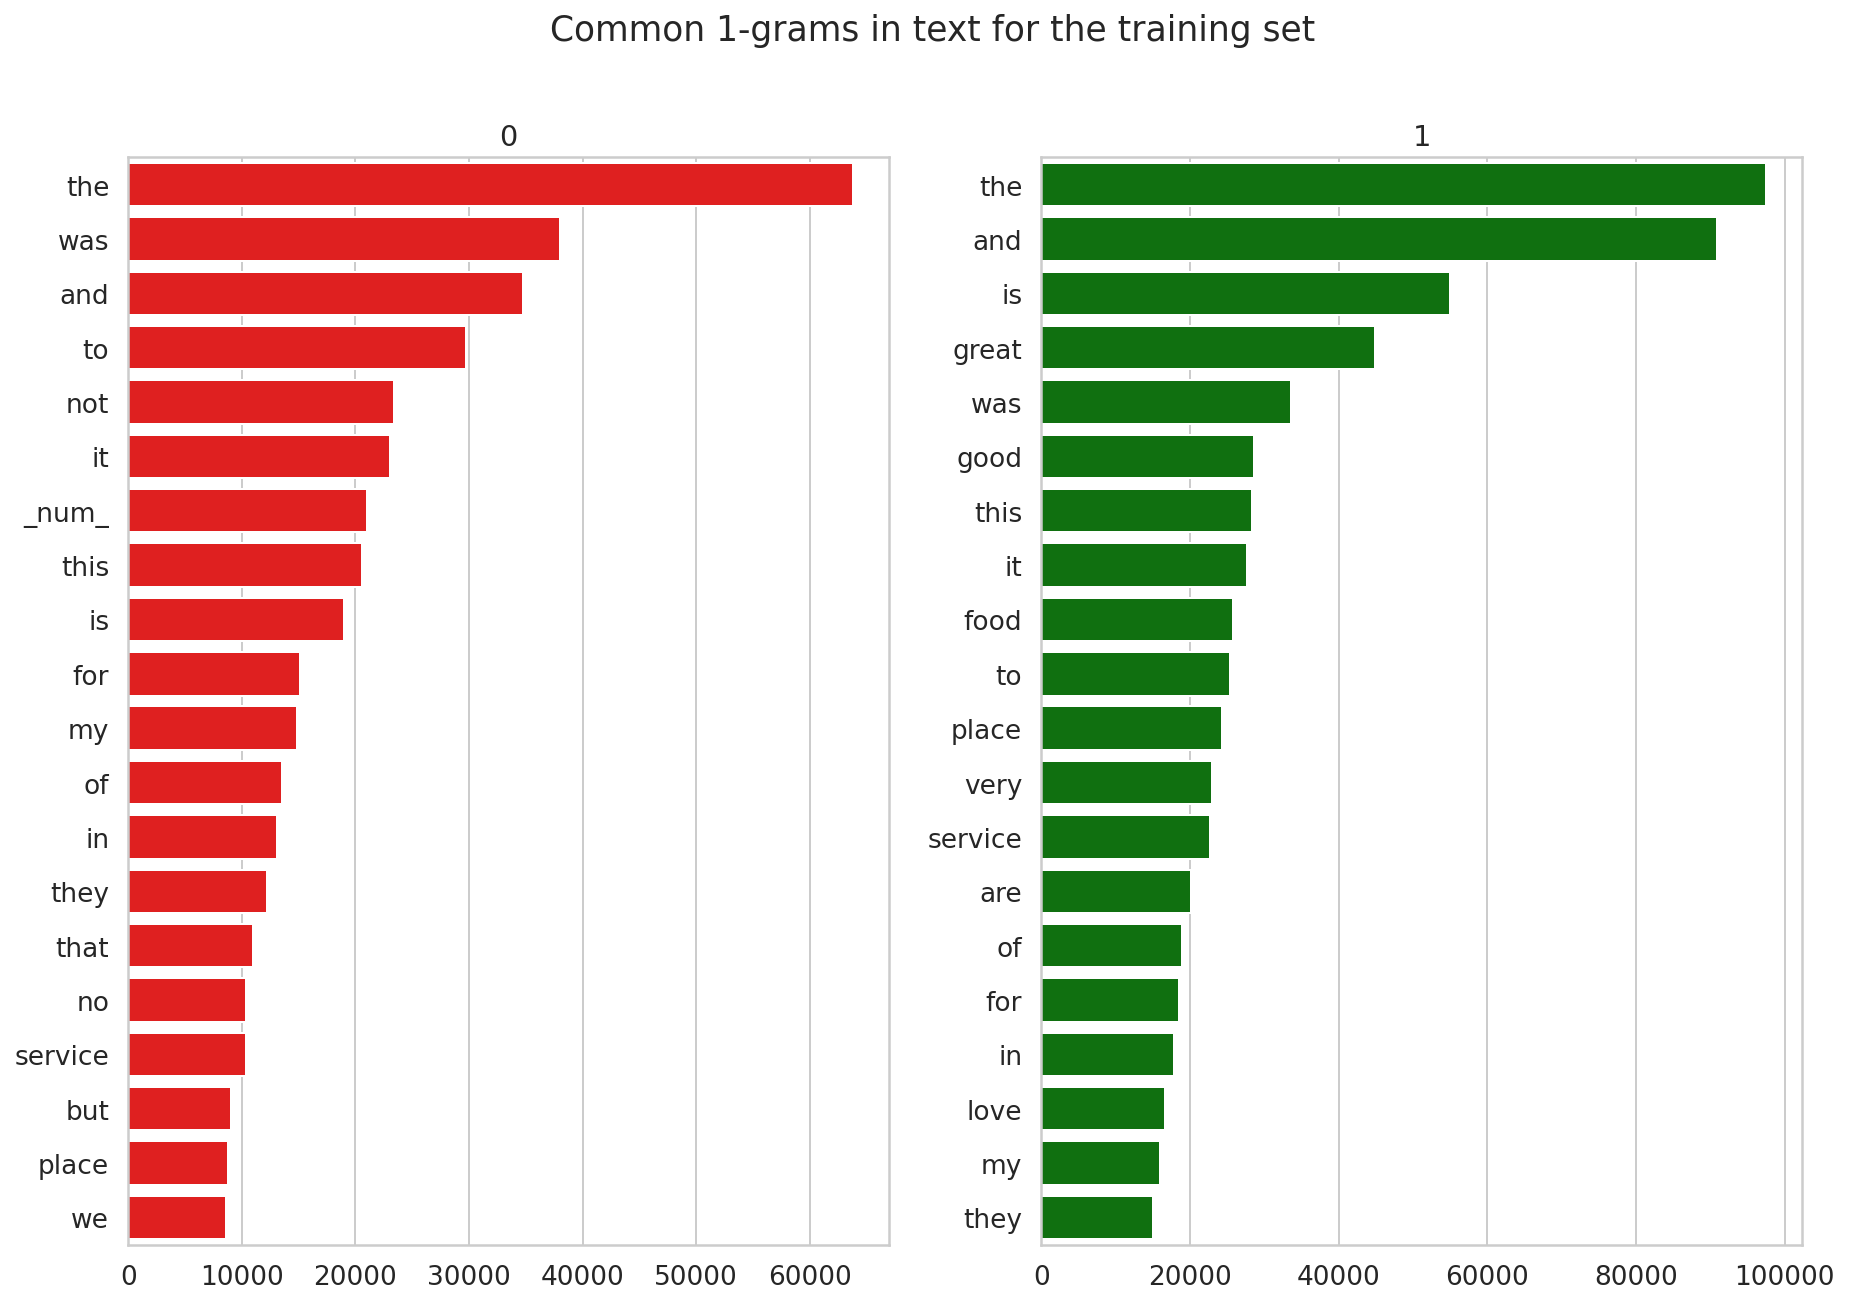

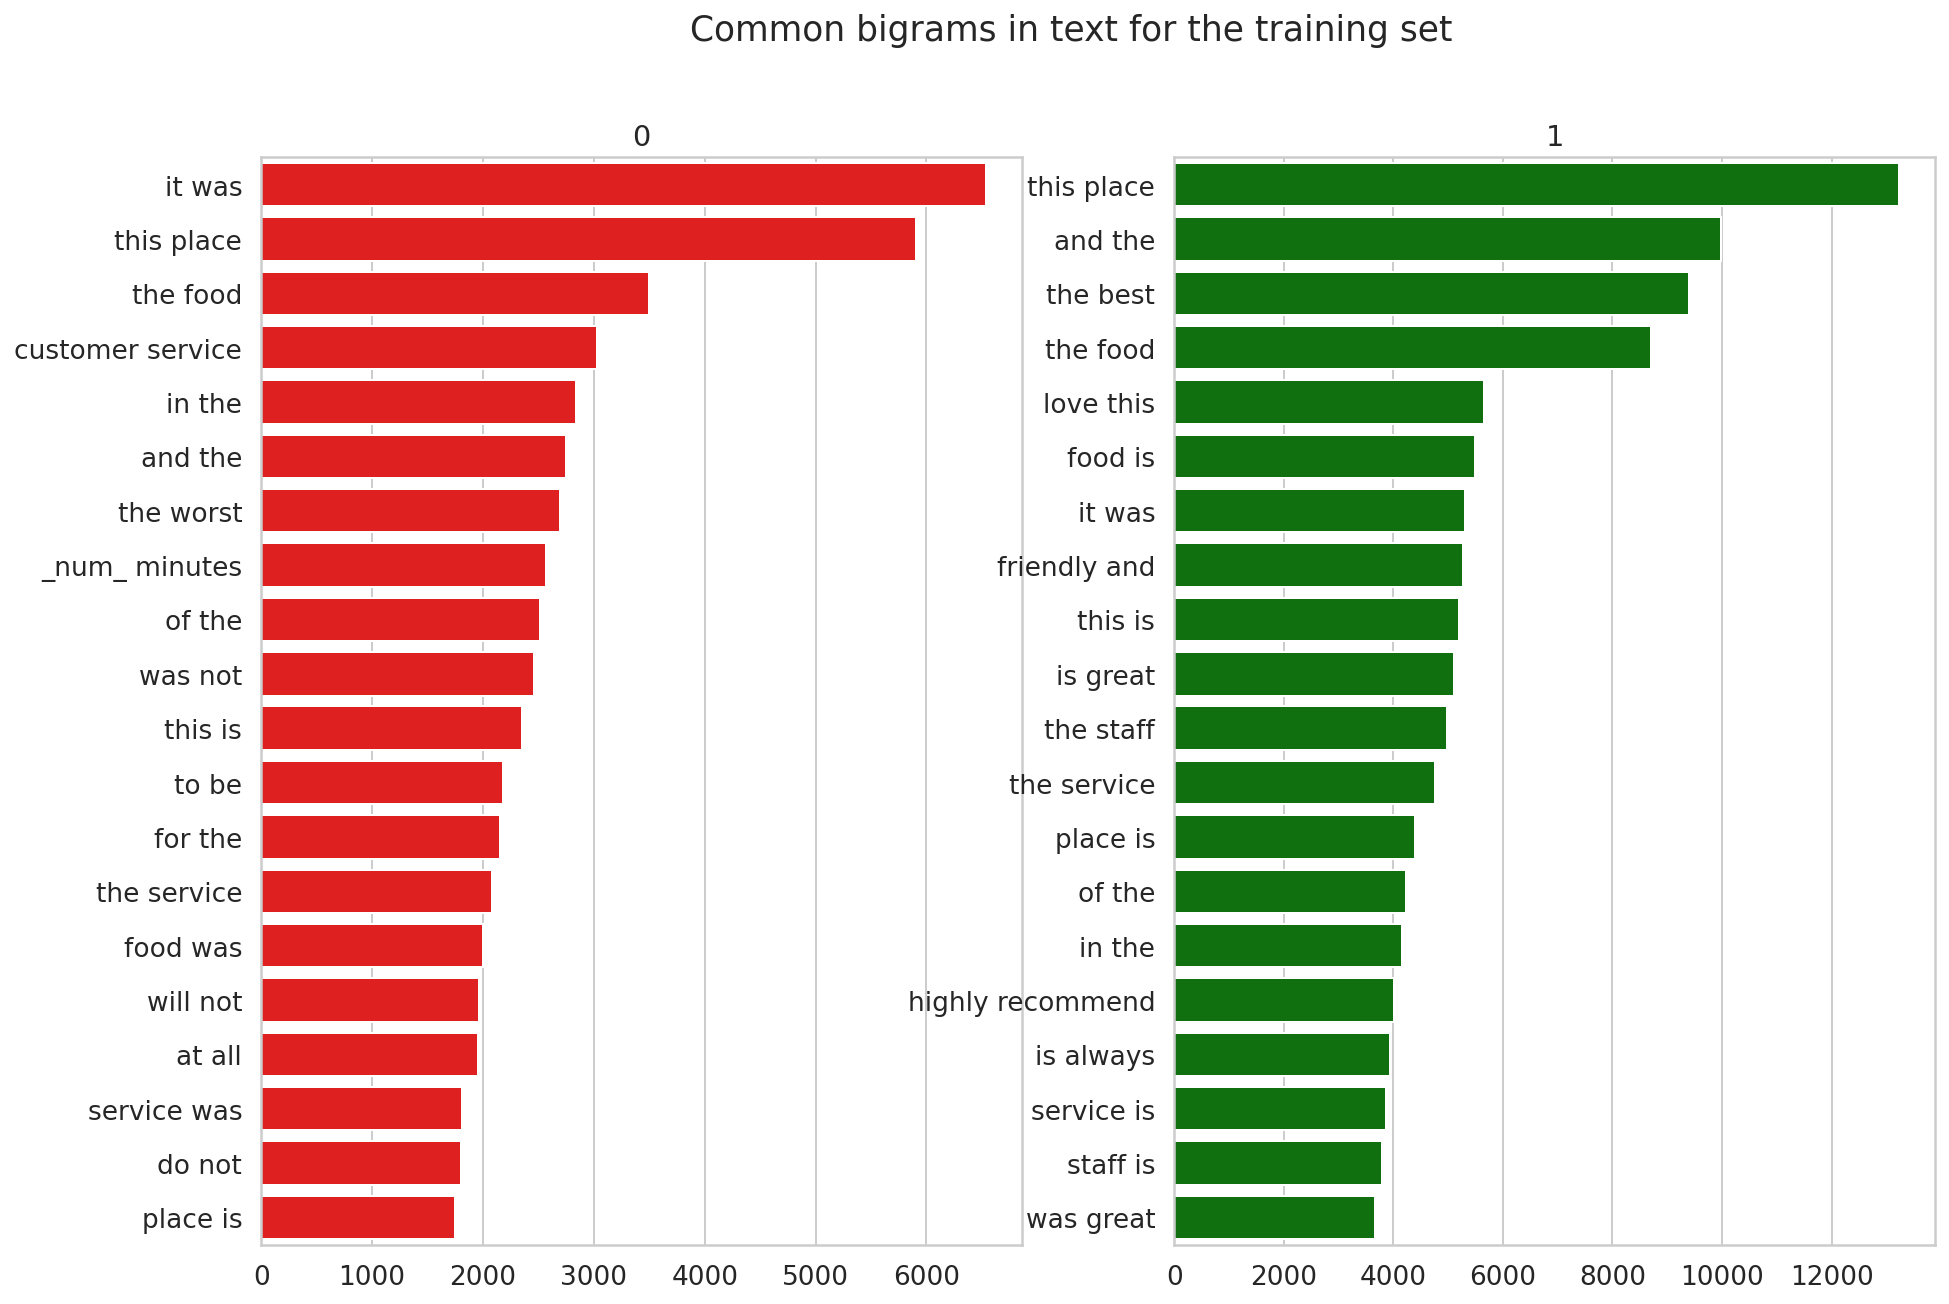

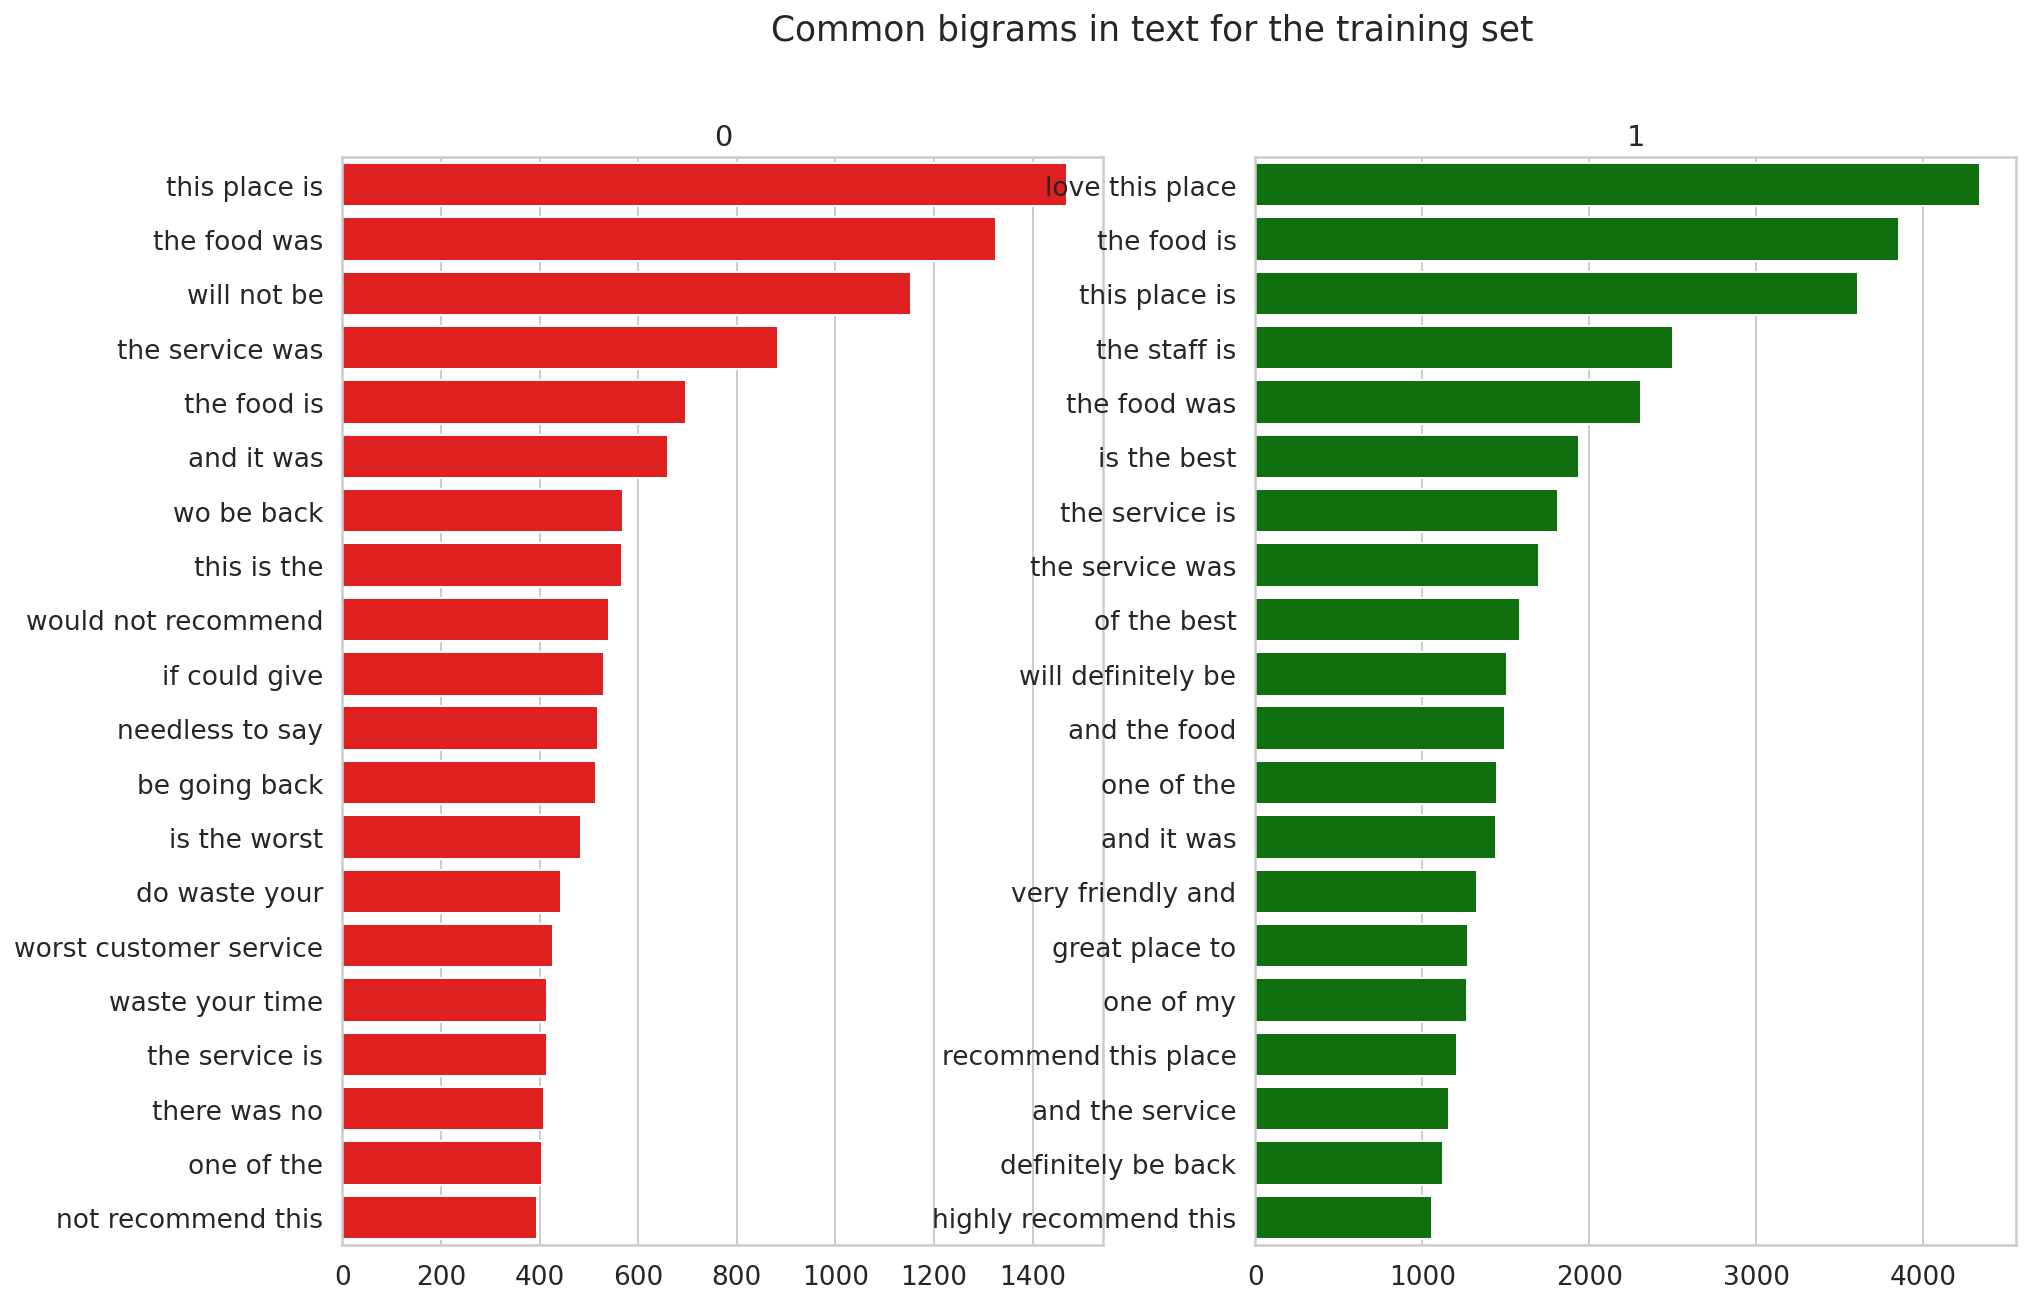

In [ ]:
plot_n_grams(train_df, size=1, 
                 title="Common 1-grams in text for the training set ",
                 column="Id")

plot_n_grams(train_df, size=2, 
                 title="Common bigrams in text for the training set",
                 column="Id")

plot_n_grams(train_df, size=3, 
                 title="Common bigrams in text for the training set",
                 column="Id")


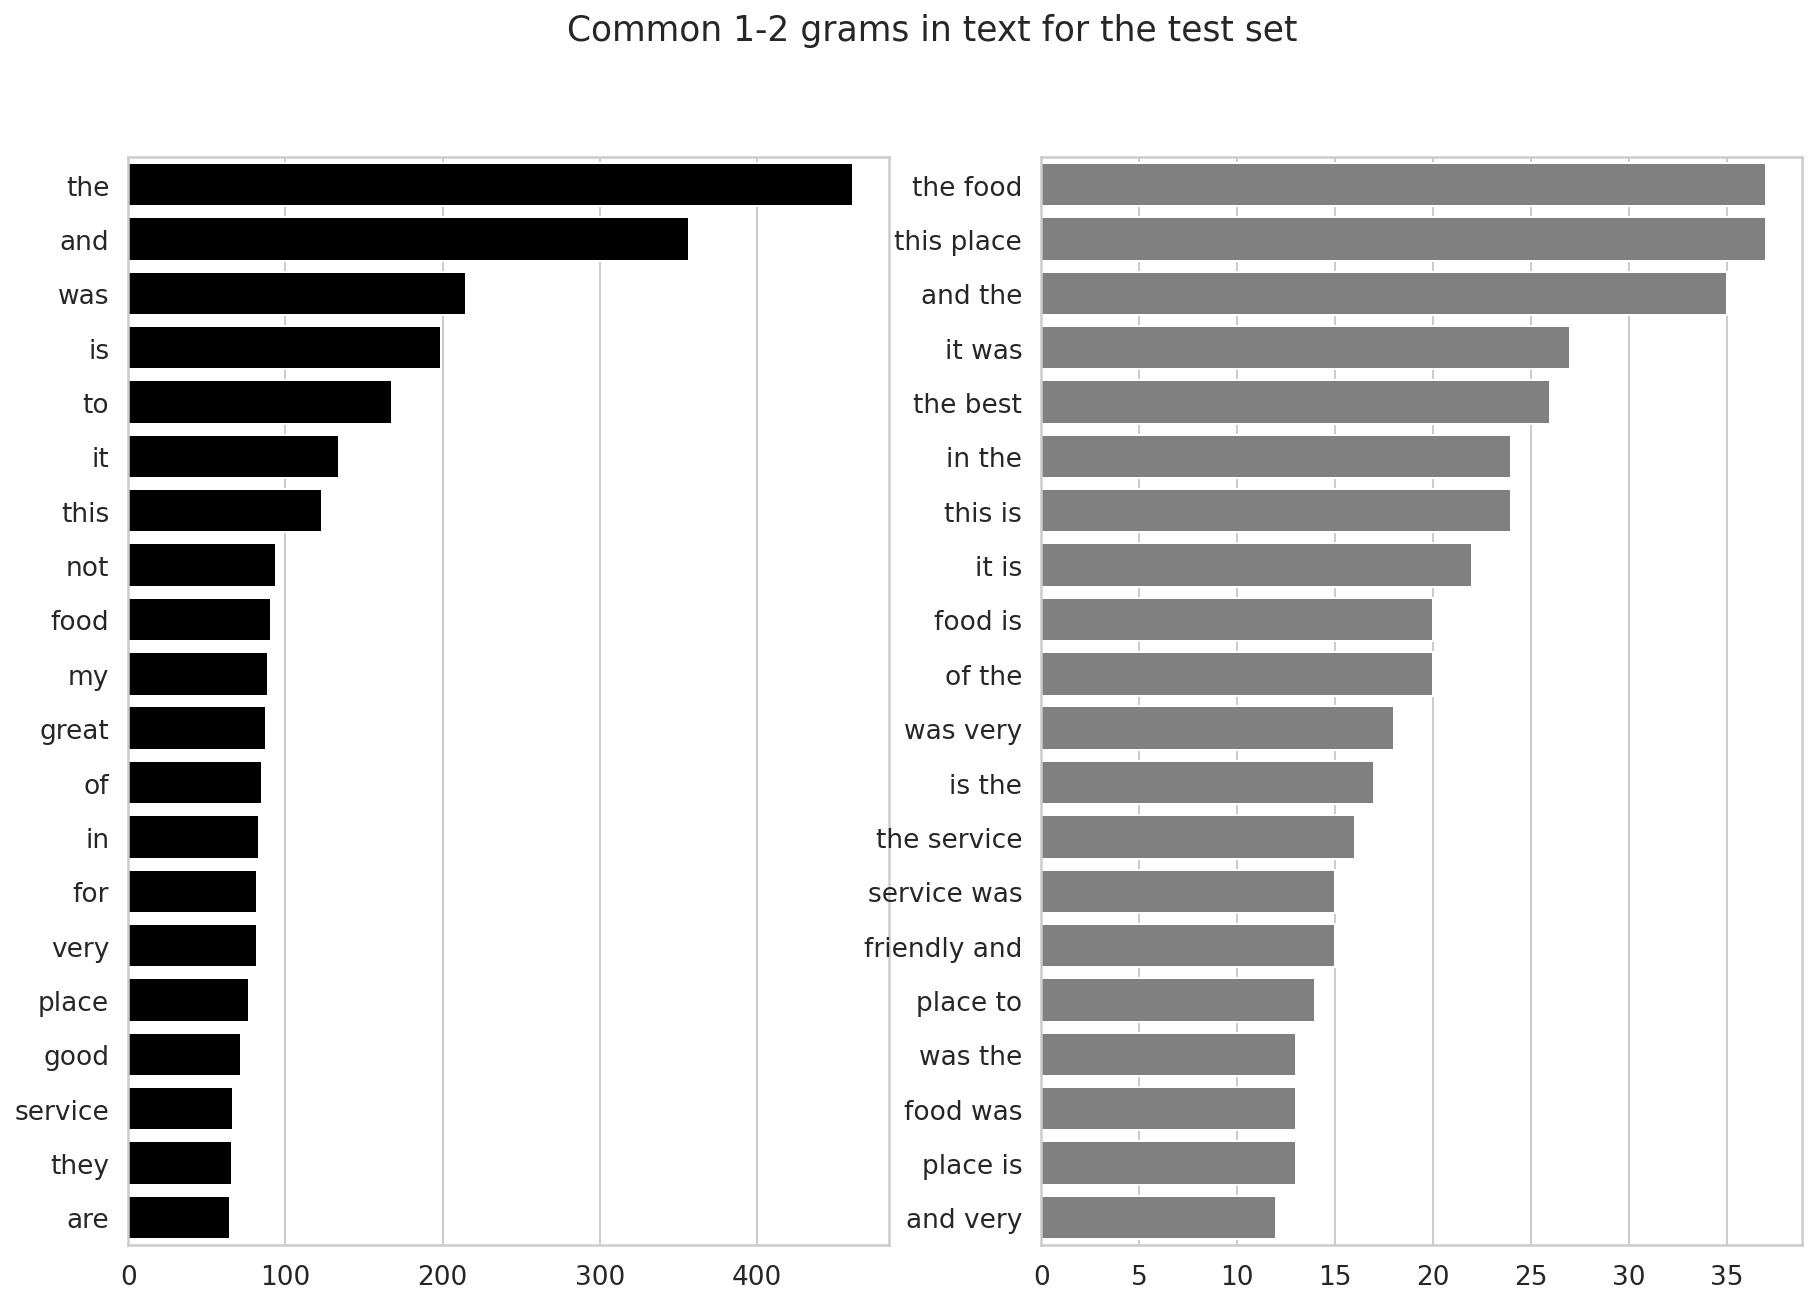

In [ ]:
plot_n_grams_test(test_df, 
                 title="Common 1-2 grams in text for the test set ",
                 column="Id")



## 3. Data Preprocessing

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train_df['temp_list'] = train_df['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub("n't"," not",text)
    text = re.sub("'s"," is",text)
    text = re.sub("'ll"," will",text)
    
    text = re.sub('!', '', text)
    #text = re.sub('.', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [ ]:
clean_text_list = []
for i, j in enumerate(tqdm(train_df.Id)):

  clean_text_list.append(clean_text(j))
train_df['Id'] = clean_text_list

  0%|          | 0/443259 [00:00<?, ?it/s]

In [ ]:
clean_text_list = []
for i, j in enumerate(tqdm(val_df.Id)):

  clean_text_list.append(clean_text(j))
val_df['Id'] = clean_text_list

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
clean_text_list = []
for i, j in enumerate(tqdm(test_df.Id)):

  clean_text_list.append(clean_text(j))
test_df['Id'] = clean_text_list

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_df[train_df['Id']=='']
val_df[val_df['Id']=='']

,Id,label,temp_list
372,,0,[?]
1676,,0,[)]
2080,,1,[!]
3389,,1,[!]


In [ ]:
train_df.head()

,Id,label,temp_list
0,i was sadly mistaken,0,"[sadly, mistaken, .]"
1,so on to the hoagies the italian is general r...,0,"[hoagies, ,, italian, general, run, mill, .]"
2,minimal meat and a ton of shredded lettuce,0,"[minimal, meat, ton, shredded, lettuce, .]"
3,nothing really special not worthy of the num...,0,"[nothing, really, special, &, worthy, $, _num_..."
4,second the steak hoagie it is atrocious,0,"[second, ,, steak, hoagie, ,, atrocious, .]"


In [ ]:

stop_sentence = []
for i, j in tqdm(enumerate(train_df.temp_list)):
  if (len(j) <= 1): 
    if ('neutral' in j) or ('negative' in j) or ('smh' in j):
      stop_sentence.append(i)

train_df = train_df.drop(list(train_df.iloc[stop_sentence].index))
train_df = train_df.drop(list(train_df[train_df['Id']==''].index))
train_df = train_df.reset_index().drop('index', axis=1)
train_df

0it [00:00, ?it/s]

,Id,label,temp_list
0,i was sadly mistaken,0,"[sadly, mistaken, .]"
1,so on to the hoagies the italian is general r...,0,"[hoagies, ,, italian, general, run, mill, .]"
2,minimal meat and a ton of shredded lettuce,0,"[minimal, meat, ton, shredded, lettuce, .]"
3,nothing really special not worthy of the num...,0,"[nothing, really, special, &, worthy, $, _num_..."
4,second the steak hoagie it is atrocious,0,"[second, ,, steak, hoagie, ,, atrocious, .]"
...,...,...,...
442024,love these donuts,1,"[love, donuts, !]"
442025,lots of smiles from everyone,1,"[lots, smiles, everyone, .]"
442026,the donuts are delicious,1,"[donuts, delicious, .]"
442027,fresh in the morning and conveniently priced,1,"[fresh, morning, conveniently, priced, .]"


In [ ]:
stop_sentence = []
for i, j in tqdm(enumerate(val_df.temp_list)):
  if (len(j) <= 1): 
    if ('neutral' in j) or ('negative' in j) or ('smh' in j):
      stop_sentence.append(i)

val_df = val_df.drop(list(val_df.iloc[stop_sentence].index))
val_df = val_df.drop(list(val_df[val_df['Id']==''].index))
val_df = val_df.reset_index().drop('index', axis=1)
val_df

0it [00:00, ?it/s]

,Id,label,temp_list
0,windows have not been cleaned in years you ca...,0,"[windows, have, n't, been, cleaned, in, years,..."
1,waitresses are slow,0,"[waitresses, are, slow, .]"
2,just a mess avoid at all costs,0,"[just, a, mess, avoid, at, all, costs, !]"
3,bad,0,"[bad, !]"
4,now pizza is beyond awful and wings are down t...,0,"[now, pizza, is, beyond, awful, and, wings, ar..."
...,...,...,...
3985,really love this place,1,"[really, love, this, place, .]"
3986,i recently moved in the area and was looking f...,1,"[i, recently, moved, in, the, area, and, was, ..."
3987,this place is amazing,1,"[this, place, is, amazing, !]"
3988,true authentic italian deli,1,"[true, authentic, italian, deli, .]"


In [ ]:
stop_sentence = []
for i, j in tqdm(enumerate(test_df.temp_list)):
  if len(j) == 1:
    stop_sentence.append(i)
test_df.iloc[stop_sentence]

0it [00:00, ?it/s]

,Id,temp_list


In [ ]:
stoken_list =[]
for i, j in enumerate(test_df.Id):
   if "smh" in j:
     stoken_list.append(i)

test_df.iloc[stoken_list]

,Id,temp_list


In [ ]:
pd.unique(train_df.iloc[stop_sentence].Id)

array([], dtype=object)

train dataset에서 단어 개수가 한개인 것들 중에서 test에 존재하지 않는 단어 : neutral, negative, smh, wow
그리고 clean_text 함수 적용결과 빈텍스트 데이터를 제외한다.

n't -> not
's -> is
'll -> will

변경한다

## 4. model

In [ ]:
class BaseDataset(Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.df = df
    self.tokenizer = tokenizer
    self.max_len = max_len
    if 'label' in df:
      self.labeled=True
      self.targets = df.label.to_numpy()
    else:
      self.labeled=False

    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, item):
    review = str(self.df['Id'][item])

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    if self.labeled:
      target = torch.tensor(self.targets[item], dtype=torch.long)    

    return {'review_text': review, 'input_ids': encoding['input_ids'].flatten(),'attention_mask': encoding['attention_mask'].flatten(),'targets': target} if self.labeled else {'review_text': review, 'input_ids': encoding['input_ids'].flatten(),'attention_mask': encoding['attention_mask'].flatten()}

In [ ]:
test_data_loader = DataLoader(BaseDataset(test_df, tokenizer, 25), batch_size=128)

In [ ]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask'])

In [ ]:
data

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[    0,   405,  1437,  ...,     1,     1,     1],
         [    0,  2527,  6770,  ...,     1,     1,     1],
         [    0,   405,    16,  ...,     1,     1,     1],
         ...,
         [    0,   877,  5836,  ...,     1,     1,     1],
         [    0,  2137,  1250,  ...,     1,     1,     1],
         [    0, 10999,   544,  ...,     1,     1,     1]]),
 'review_text': ['it  is a whole new experience and new flavors each time you go ',
  'so disappointing from an old favorite ',
  'it is the most authentic thai in the valley ',
  'do not sign a lease with these people ',
  'i was nervous and she made me feel so comfortable and welcome ',
  'the only thing we received that was hot was the coffee ',
  'no  not the ones at

In [ ]:
class ReadabilityModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.Roberta = RobertaForSequenceClassification.from_pretrained(MODEL_NAME)

  def forward(self, input_ids, attention_mask, labels=None):

    output = self.Roberta(
    input_ids=input_ids,
    attention_mask=attention_mask
    )
    if labels is not None:
      output = self.Roberta(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels=labels
      )
      return output
    return output
    

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["targets"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss
    
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["targets"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss


  def configure_optimizers(self):
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
        #lr_scheduler = get_constant_schedule_with_warmup(optimizer, 100)
    return optimizer
    


In [ ]:
train_df=train_df.reset_index().drop('index',axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

In [ ]:
BATCH_SIZE = 256
MAX_LEN = 25

train_data_loader = DataLoader(BaseDataset(train_df, tokenizer, MAX_LEN),  batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_data_loader = DataLoader(BaseDataset(val_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_data_loader = DataLoader(BaseDataset(test_df, tokenizer, MAX_LEN), batch_size=1000, shuffle=False, num_workers=2)

In [ ]:
model = ReadabilityModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_callback = ModelCheckpoint(
    filename="/content/drive/MyDrive/Colab Notebooks/LG_project/data",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")


In [ ]:
trainer = pl.Trainer(
    # logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=15,
    gpus=1,
    progress_bar_refresh_rate=30)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                             | Params
-------------------------------------------------------------
0 | Roberta | RobertaForSequenceClassification | 124 M 
-------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.589   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1726: val_loss reached 0.06200 (best 0.06200), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3453: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 5180: val_loss reached 0.06126 (best 0.06126), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6907: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 8634: val_loss was not in top 1


In [ ]:
trained_model = ReadabilityModel.load_from_checkpoint(
    "/content/drive/MyDrive/Colab Notebooks/LG_project/data.ckpt"
) 

trained_model.freeze()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
data = next(iter(test_data_loader))

In [ ]:
predictions = []
input_ids = data['input_ids']
attention_mask = data['attention_mask']


output = trained_model(input_ids=input_ids,
                       attention_mask=attention_mask)

output.logits
batch_predictions = [0 if example[0] > example[1] else 1 for example in output.logits]
predictions += batch_predictions
len(predictions)

1000

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/test_no_label.csv')

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df

,Id,temp_list,Category
0,it is a whole new experience and new flavors ...,"[it, 's, a, whole, new, experience, and, new, ...",1
1,so disappointing from an old favorite,"[so, disappointing, from, an, old, favorite, .]",0
2,it is the most authentic thai in the valley,"[it, is, the, most, authentic, thai, in, the, ...",1
3,do not sign a lease with these people,"[do, not, sign, a, lease, with, these, people, .]",0
4,i was nervous and she made me feel so comforta...,"[i, was, nervous, and, she, made, me, feel, so...",1
...,...,...,...
995,the food here is delicious,"[the, food, here, is, delicious, .]",1
996,we will certainly be back,"[we, 'll, certainly, be, back, !]",1
997,the building itself looks abandoned,"[the, building, itself, looks, abandoned, .]",0
998,if i could give zero stars i def would,"[if, i, could, give, zero, stars, i, def, woul...",0


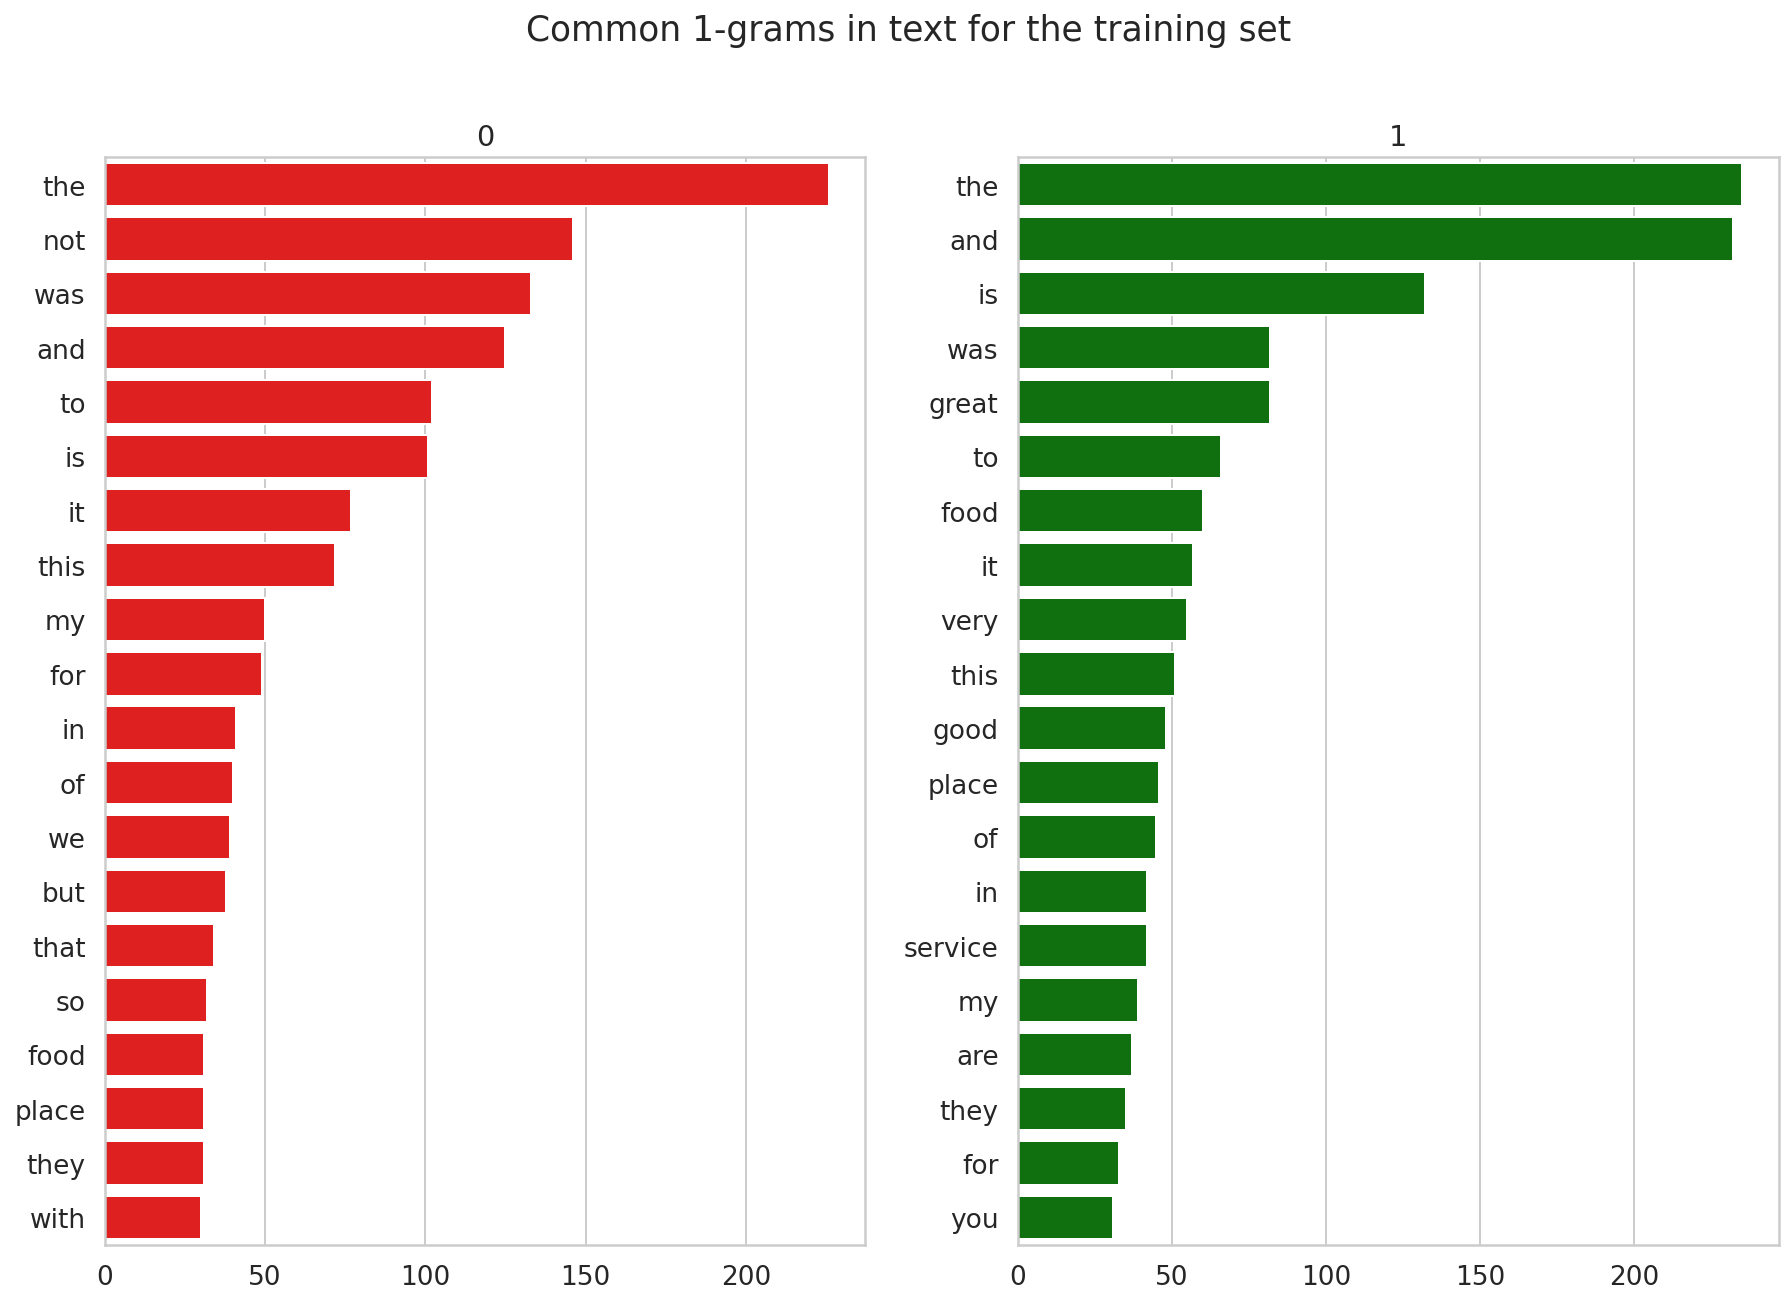

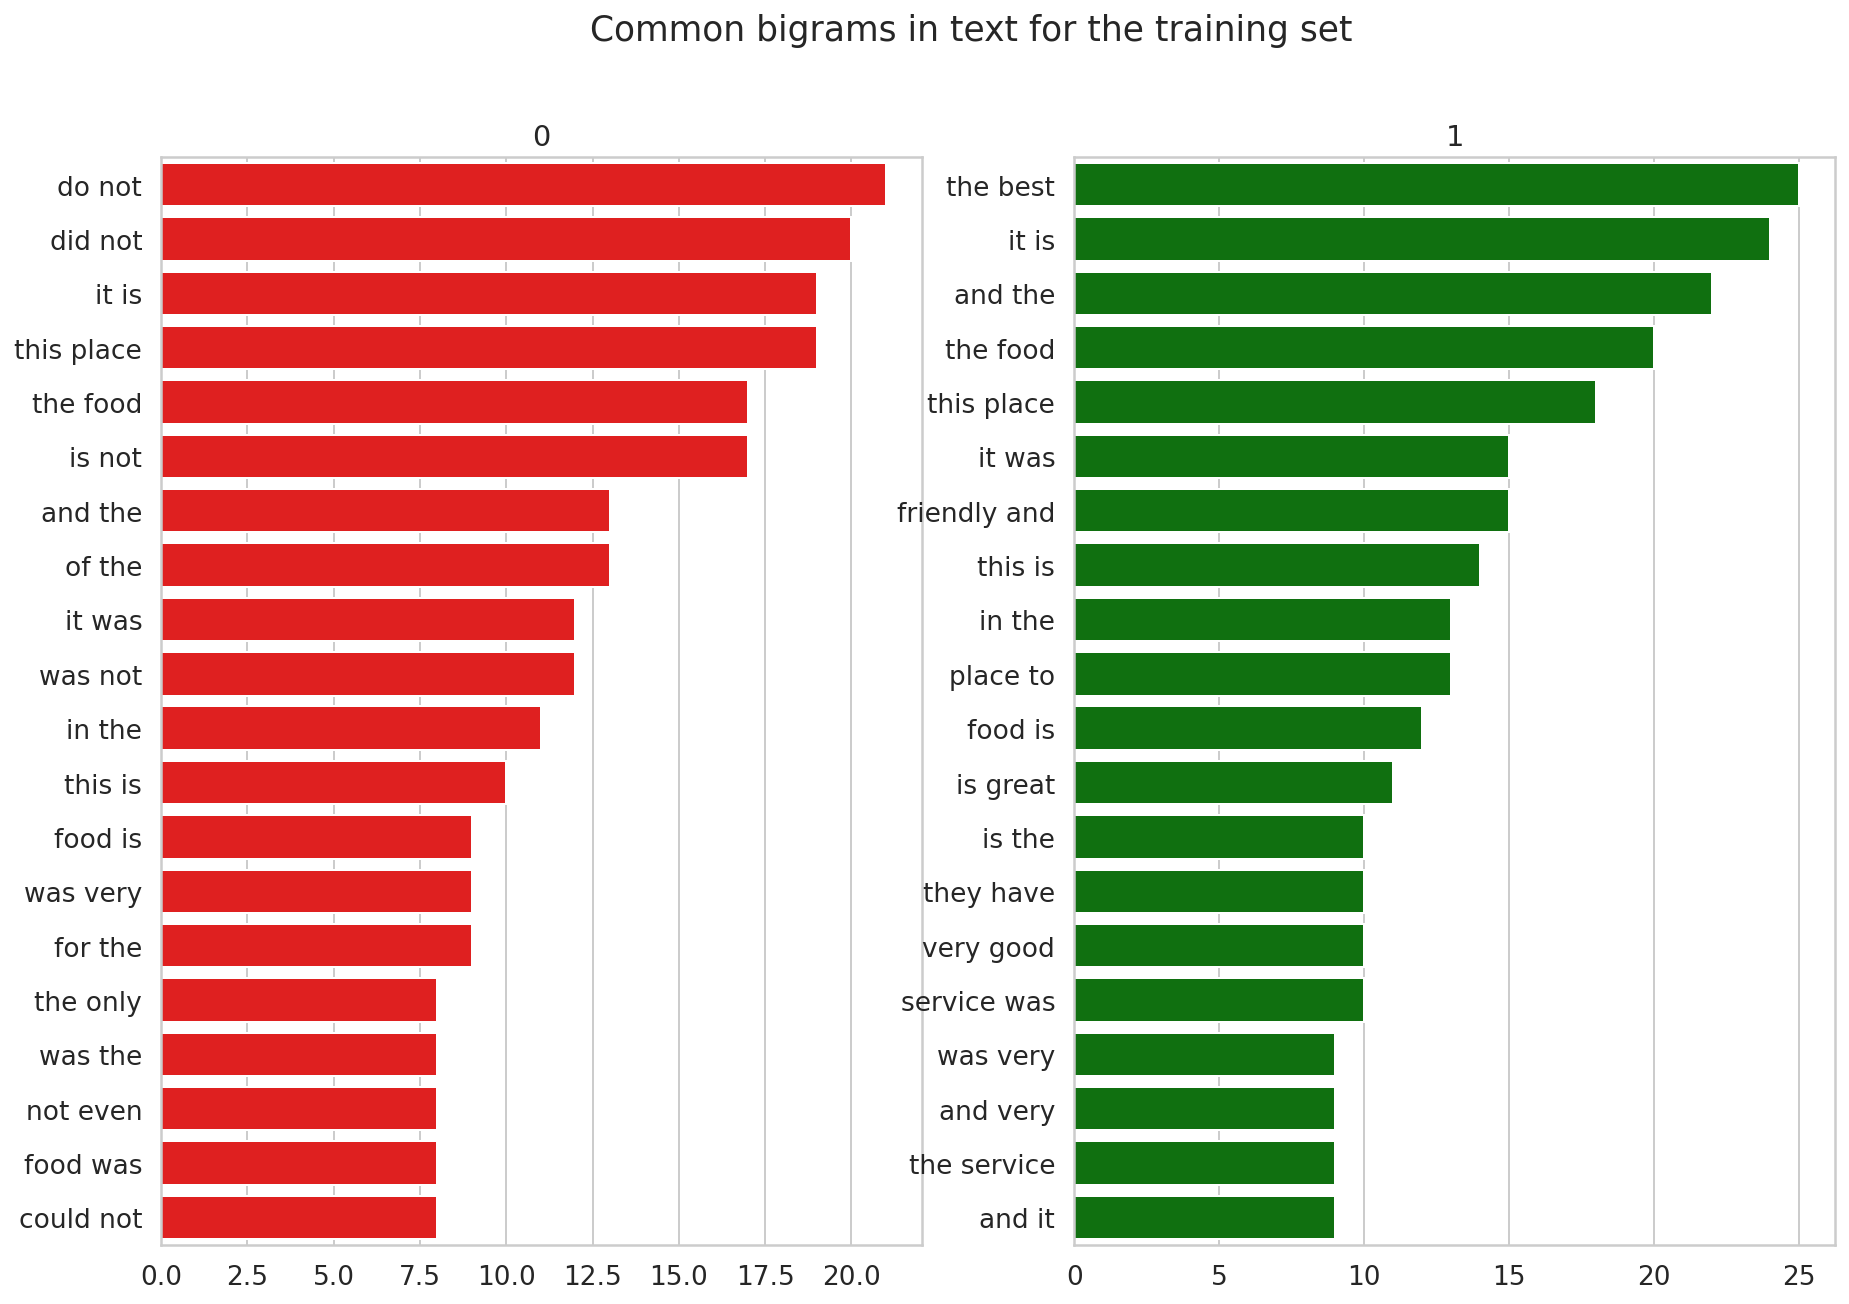

In [ ]:
plot_n_grams(test_df, size=1, 
                 title="Common 1-grams in text for the training set ",
                 label='Category',
                 column="Id")

plot_n_grams(test_df, size=2, 
                 title="Common bigrams in text for the training set",
             label='Category',
                 column="Id")


In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/submission_roberta.csv', index=False)


validation_data에서 확인


In [ ]:
visual_val_df = DataLoader(BaseDataset(val_df, tokenizer, MAX_LEN), batch_size=4000, shuffle=False, num_workers=2)

In [ ]:
data = next(iter(visual_val_df))
input_ids = data['input_ids']
attention_mask = data['attention_mask']


output = trained_model(input_ids=input_ids,
                       attention_mask=attention_mask)

output.logits
batch_predictions = [0 if example[0] > example[1] else 1 for example in output.logits]
len(batch_predictions)

3990

In [ ]:
val_df['Category'] = batch_predictions

In [ ]:
val_df

,Id,label,temp_list,Category
0,windows have not been cleaned in years you ca...,0,"[windows, have, n't, been, cleaned, in, years,...",0
1,waitresses are slow,0,"[waitresses, are, slow, .]",0
2,just a mess avoid at all costs,0,"[just, a, mess, avoid, at, all, costs, !]",0
3,bad,0,"[bad, !]",0
4,now pizza is beyond awful and wings are down t...,0,"[now, pizza, is, beyond, awful, and, wings, ar...",0
...,...,...,...,...
3985,really love this place,1,"[really, love, this, place, .]",1
3986,i recently moved in the area and was looking f...,1,"[i, recently, moved, in, the, area, and, was, ...",1
3987,this place is amazing,1,"[this, place, is, amazing, !]",1
3988,true authentic italian deli,1,"[true, authentic, italian, deli, .]",1


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(val_df.label, val_df.Category)

array([[1955,   39],
       [  39, 1957]])

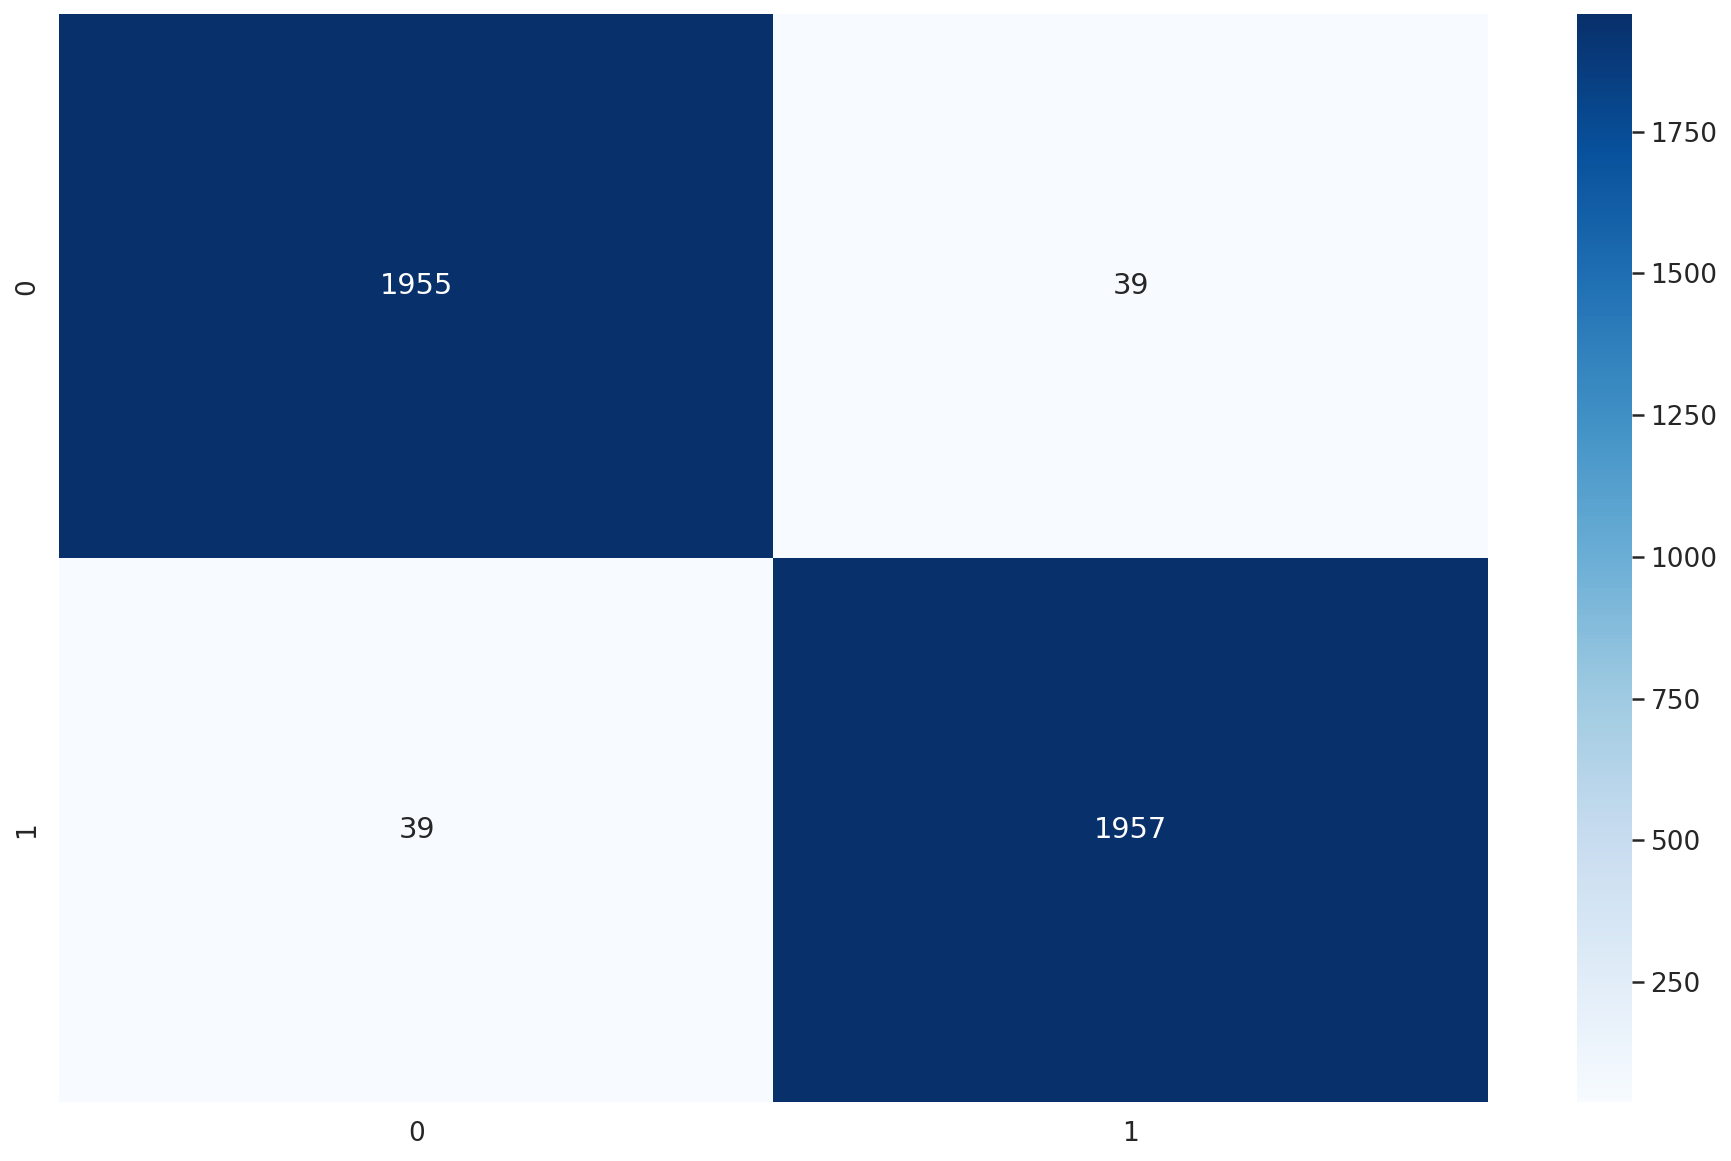

In [ ]:
sns.heatmap(data=confusion_matrix(val_df.label, val_df.Category), annot=True, fmt='d', cmap='Blues')

In [ ]:
import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(val_df.label,val_df.Category) )

print('precision', metrics.precision_score(val_df.label,val_df.Category) )

print('recall', metrics.recall_score(val_df.label,val_df.Category) )

print('f1', metrics.f1_score(val_df.label,val_df.Category) )

accuracy 0.9804511278195489
precision 0.9804609218436874
recall 0.9804609218436874
f1 0.9804609218436874


In [ ]:
val_df[val_df['label']!=val_df['Category']]

,Id,label,temp_list,Category
158,she rings me up and hands me one cup,0,"[she, rings, me, up, and, hands, me, one, cup, .]",1
184,i keep trying to give this place a chance,0,"[i, keep, trying, to, give, this, place, a, ch...",1
269,the bathrooms were very clean and the booth we...,0,"[the, bathrooms, were, very, clean, and, the, ...",1
272,i spoke with a manager erica martin about our...,0,"[i, spoke, with, a, manager, ,, erica, martin,...",1
288,i will never set foot inside another macayo i...,0,"[i, will, never, set, foot, inside, another, m...",1
...,...,...,...,...
3612,num bucks,1,"[_num_, $, bucks, !]",0
3843,for a moment i thought i m eating mom food,1,"[for, a, moment, i, thought, i, 'm, eating, mo...",0
3924,if you have not been here or are thinking of ...,1,"[if, you, have, n't, been, here, or, are, thin...",0
3925,when i took my first bite i was brought back t...,1,"[when, i, took, my, first, bite, i, was, broug...",0


In [ ]:
stoken_list =[]
for i, j in enumerate(train_df.Id):
   if 'not' in j:
     stoken_list.append(i)


In [ ]:
train_df.iloc[stoken_list]

,Id,label,temp_list
3,nothing really special not worthy of the num...,0,"[nothing, really, special, &, worthy, $, _num_..."
8,i was not going to pay for the dressing on the...,0,"[going, pay, dressing, side, .]"
21,we will not be back,0,"[back, .]"
31,do not waste your time,0,"[n't, waste, time, .]"
32,not a call not the estimate nothing,0,"[call, ,, estimate, ,, nothing, .]"
...,...,...,...
441740,small little shop but the customer service and...,1,"[small, little, shop, customer, service, food,..."
441750,i am not a big meat eater but this burger was...,1,"[big, meat, eater, ,, burger, really, good, .]"
441899,fun place to go and it does not hurt the wallet,1,"[fun, place, go, n't, hurt, wallet, .]"
441914,it is nothing fancy but it hits the spot,1,"['s, nothing, fancy, hits, spot, .]"


In [ ]:
stoken_list =[]
for i, j in enumerate(train_df.Id):
   if "n't" in j:
     stoken_list.append(i)

train_df.iloc[stoken_list]

,Id,label,temp_list


In [ ]:
train_df
print(train_df[train_df['Id']=='!'])



Empty DataFrame
Columns: [Id, label, temp_list]
Index: []


In [ ]:
print(train_df[train_df['Id']=='neutral'])

Empty DataFrame
Columns: [Id, label, temp_list]
Index: []


In [ ]:

set(test_df.Id).intersection(set(val_df.Id))

{'we will not be coming back '}

In [ ]:
test_df

,Id,temp_list,Category
0,it is a whole new experience and new flavors ...,"[it, 's, a, whole, new, experience, and, new, ...",1
1,so disappointing from an old favorite,"[so, disappointing, from, an, old, favorite, .]",0
2,it is the most authentic thai in the valley,"[it, is, the, most, authentic, thai, in, the, ...",1
3,do not sign a lease with these people,"[do, not, sign, a, lease, with, these, people, .]",0
4,i was nervous and she made me feel so comforta...,"[i, was, nervous, and, she, made, me, feel, so...",1
...,...,...,...
995,the food here is delicious,"[the, food, here, is, delicious, .]",1
996,we will certainly be back,"[we, 'll, certainly, be, back, !]",1
997,the building itself looks abandoned,"[the, building, itself, looks, abandoned, .]",0
998,if i could give zero stars i def would,"[if, i, could, give, zero, stars, i, def, woul...",0
